# 피마 인디언 당뇨병 데이터

- 데이터 활용 목적 : 당뇨병 여부를 판단하는 머신러닝 예측 모델을 개발
- 데이터 개요
    - 북아메리 피마 지역 원주민의 Type-2 당뇨병 결과 데이터
    - 일반적으로 알려진 당뇨병의 원인은 식습관과 유전
        - 피마 지역은 고립된 지역에서 인디언 고유의 혈통이 지속됨
        - 20세기 후반 서구화된 식습관으로 많은 당뇨 환자가 발생
        
    - 피처
        - Pregnancies : 임신 횟수
        - Glucose : 포도당 부하 검사 수치
        - BloodPressure : 혈압 (mm Hg)
        - SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값
        - Insulin : 혈청 인슐린(mm U/ml)
        - BMI : 체질량 지수 (체중(kg)) / 키(m))^2
        - DiabetesPedigreeFunction : 당뇨 내력 가중치 값
        - Age : 나이
        - Outcome : 클래스 결정 값(0 또는 1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import (auc, roc_auc_score, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score,
                             f1_score, confusion_matrix, precision_recall_curve, roc_curve)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, DBSCAN
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore")

### 데이터 읽기 및 확인

In [2]:
df = pd.read_csv("./data/diabetes.csv")

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.shape

(768, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### 데이터 분석 및 시각화

In [7]:
corr = df.corr()

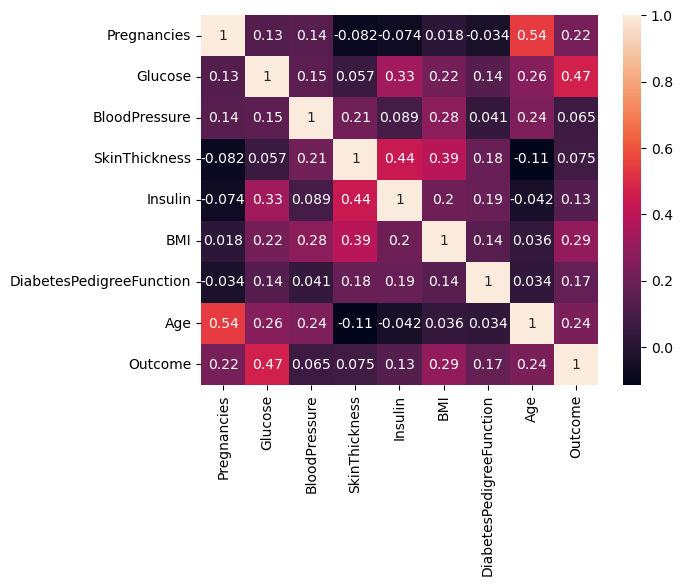

In [8]:
sns.heatmap(corr, annot = True, cbar = True)

plt.show()

- Outcome과 상관성이 유의미하다고 보이는 피처는 Glucose 하나
- 넓게 봐준다면 Pregnancies, BMI, Age, DiabetesPedigreeFunction, Insulin 정도까지
- BloodPressure, SkinThickness는 드랍해도 무관할것으로 생각됨

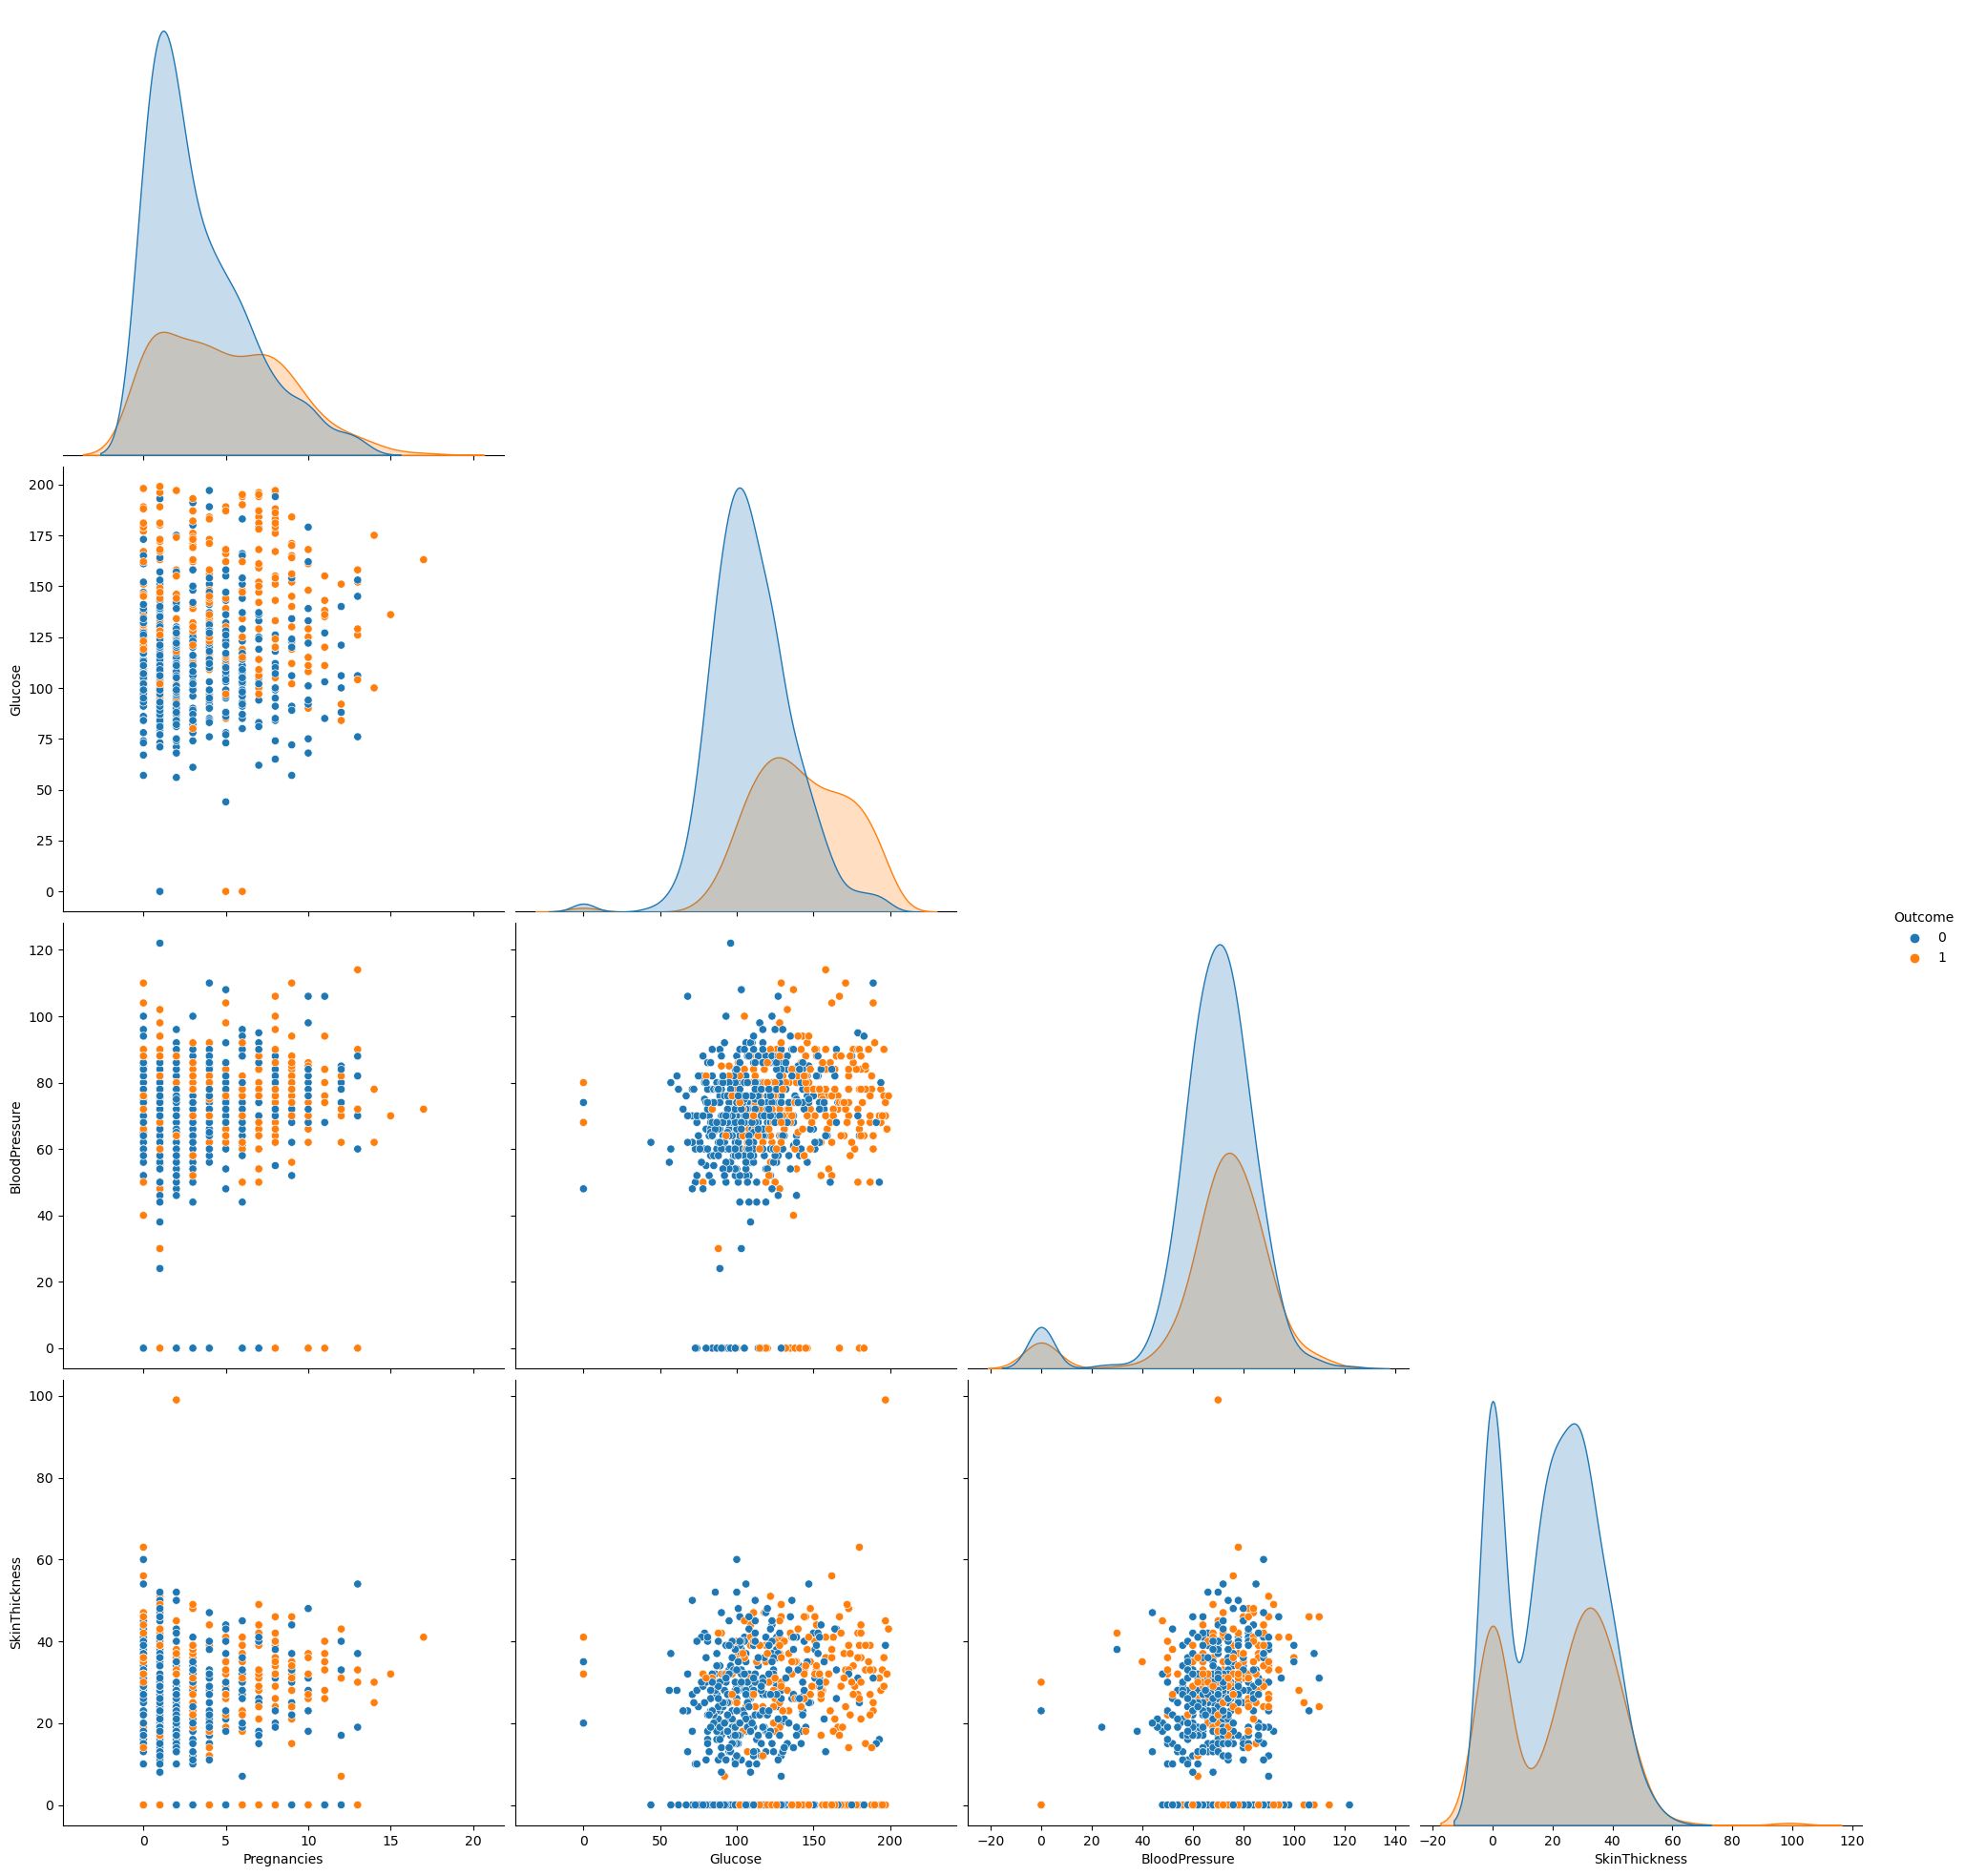

In [9]:
# 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness' 페어플롯 시각화
sns.pairplot(df.iloc[:, [0, 1, 2, 3, -1]], diag_kind = "kde", hue = "Outcome", corner = True, height = 5)
plt_kws = {"s" : 100}

plt.show()

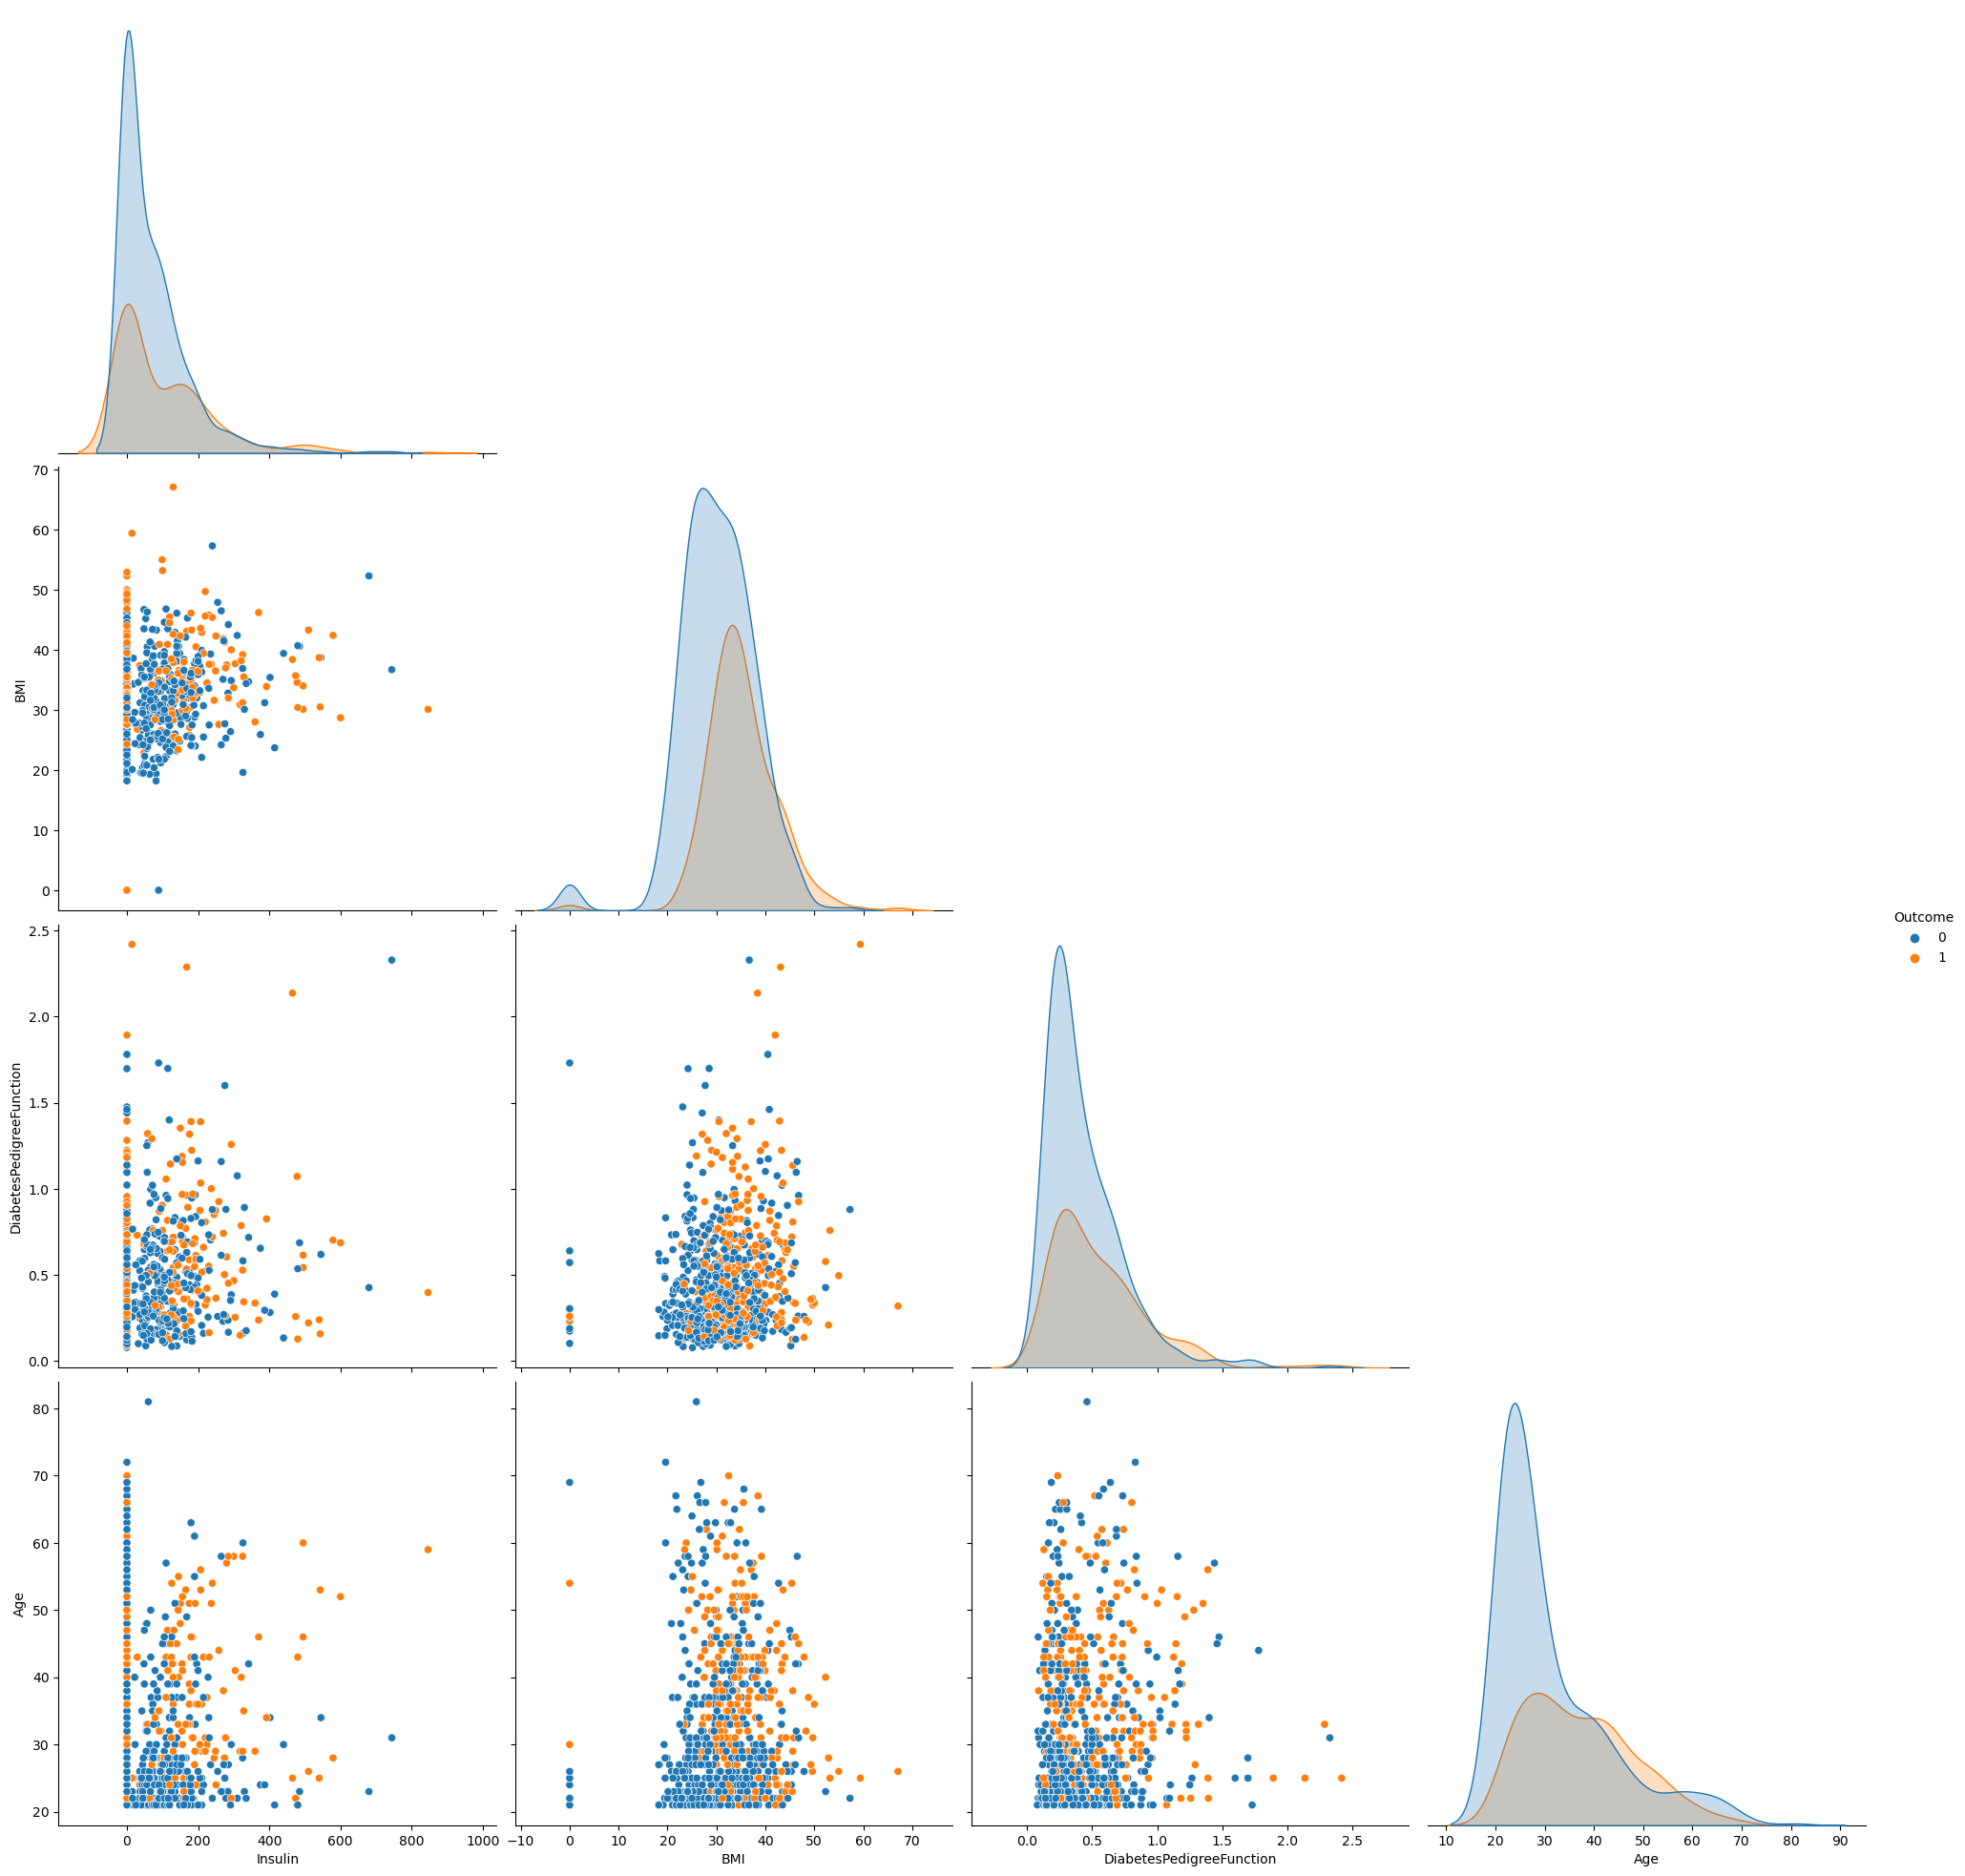

In [10]:
# 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age' 페어플롯 시각화
sns.pairplot(df.iloc[:, [4, 5, 6, 7, -1]], diag_kind = "kde", hue = "Outcome", corner = True, height = 5)

plt_kws = {"s" : 100}

plt.show()

### 결측치 확인

- 다음의 항목은 값이 0일 경우 결측치라고 판단할 수 있는 항목들은 다음과 같음
- 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'
- 상식적으로 insulin 값은 당뇨병과 깊은 연관이 있을 것으로 생각되지만 결측치가 절반에 달함...

In [11]:
len(df.loc[df["Glucose"] == 0])

5

In [12]:
len(df.loc[df["BloodPressure"] == 0])

35

In [13]:
len(df.loc[df["SkinThickness"] == 0])

227

In [14]:
len(df.loc[df["Insulin"] == 0])

374

In [15]:
len(df.loc[df["BMI"] == 0])

11

#### 결측치가 아닌 데이터들과의 상관관계

In [16]:
df[["BloodPressure", "Outcome"]].loc[df["BloodPressure"] != 0].corr()

,BloodPressure,Outcome
BloodPressure,1.000000,0.170589
Outcome,0.170589,1.000000


In [17]:
df[["SkinThickness", "Outcome"]].loc[df["SkinThickness"] != 0].corr()

,SkinThickness,Outcome
SkinThickness,1.000000,0.259491
Outcome,0.259491,1.000000


In [18]:
# df[["Insulin", "Outcome"]].loc[df["Insulin"] != 0].corr()

- 상관계수에서 의미 없었던 것으로 밝혀진 BloodPressure는 결측치 비율이 약 5%
    - 결측치를 제외한 나머지 데이터의 상관계수 역시 0.17로 높지 않음
    
- SkinThickness는 결측치가 약 1/3에 달하는 수준
    - 결측치를 제외한 나머지 데이터의 상관계수는 0.25정도로 약간 아쉬운 수준
    
- insulin은 결측치가 1/2 비율
    - 결측치를 제외한 데이터의 상관계수는 0.3으로 양호한 편
    - 하지만 결측치가 너무 많아 드롭하는 것이 적절할 것으로 판단됨...
    
- Glucose, BMI는 결측치의 수도 적으며 상관계수도 비교적 높은편
    - 평균값으로 대체해도 무관하지 않을까 생각됨

# 데이터 전처리

### SkinThickness, Insulin 드롭

In [19]:
ndf = df.drop(["SkinThickness", "Insulin"], axis = 1)

- 왜인지 이해할 수 없으나 BloodPressure 피처를 포함한 경우가 근소하게 점수가 높음

In [20]:
ndf.head()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,33.6,0.627,50,1
1,1,85,66,26.6,0.351,31,0
2,8,183,64,23.3,0.672,32,1
3,1,89,66,28.1,0.167,21,0
4,0,137,40,43.1,2.288,33,1


### BMI, Glucose, BloodPressure 결측치 평균값으로 대체

In [21]:
ndf["Glucose"][ndf["Glucose"] == 0] = round(ndf["Glucose"][ndf["Glucose"] != 0].mean(), 0)

In [22]:
ndf["BMI"][ndf["BMI"] == 0] = round(ndf["BMI"][ndf["BMI"] != 0].mean(), 0)

In [23]:
ndf["BloodPressure"][ndf["BloodPressure"] == 0] = round(ndf["BloodPressure"][ndf["BloodPressure"] != 0].mean(), 0)

In [24]:
# ndf["Insulin"][ndf["Insulin"] == 0] = round(ndf["Insulin"][ndf["Insulin"] != 0].mean(), 0)

#### Glucose와 BMI의 이상치 확인

In [25]:
ndf[["Glucose", "BMI"]].describe()

,Glucose,BMI
count,768.000000,768.000000
mean,121.688802,32.450911
std,30.435959,6.875366
min,44.000000,18.200000
25%,99.750000,27.500000
50%,117.000000,32.000000
75%,140.250000,36.600000
max,199.000000,67.100000


In [26]:
plt.style.use("classic")

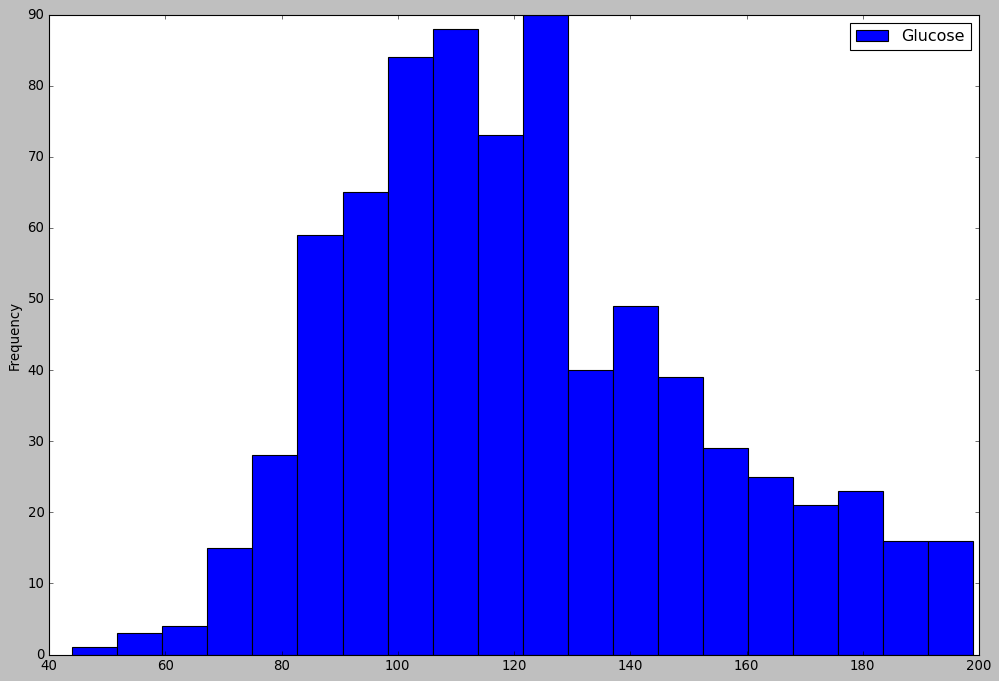

In [27]:
ndf[["Glucose"]].plot(kind = "hist", bins = 20, figsize = (15, 10))

plt.show()

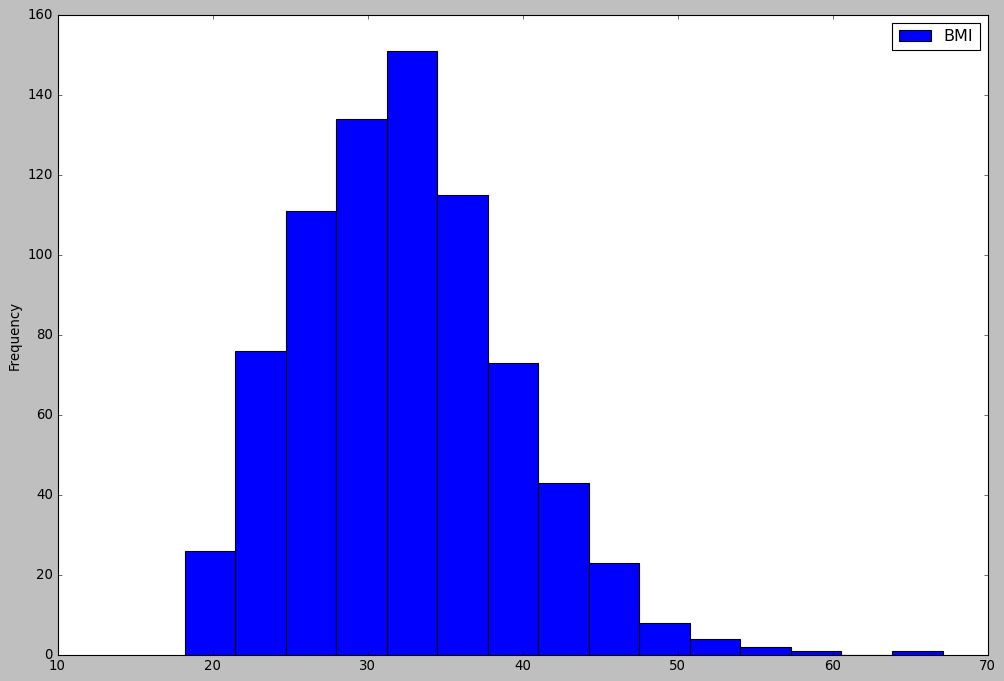

In [28]:
ndf[["BMI"]].plot(kind = "hist", bins = 15, figsize = (15, 10))

plt.show()

- Glucose는 60이하인 경우, BMI는 55이상인 경우가 이상치로 판단됨 
- Glucose는 과연 이상치를 제거할 필요까지 있을지 고민해볼 필요가 있음

In [29]:
ndf.loc[ndf["Glucose"] <= 60]

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
62,5,44,62,25.0,0.587,36,0
146,9,57,80,32.8,0.096,41,0
537,0,57,60,21.7,0.735,67,0
680,2,56,56,24.2,0.332,22,0


In [30]:
ndf.loc[ndf["BMI"] >= 55]

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
125,1,88,30,55.0,0.496,26,1
177,0,129,110,67.1,0.319,26,1
445,0,180,78,59.4,2.420,25,1
673,3,123,100,57.3,0.880,22,0


In [31]:
ndf = ndf.drop(ndf.loc[(ndf["Glucose"] <= 60) | (ndf["BMI"] >= 55)].index, axis = 0)

In [32]:
ndf.shape

(760, 7)

#### x, y 분할

In [33]:
x = ndf.drop("Outcome", axis = 1)
y = ndf["Outcome"]

#### 언더샘플링 시도

In [34]:
ndf["Outcome"].value_counts()

Outcome
0    495
1    265
Name: count, dtype: int64

In [35]:
under_x, under_y = RandomUnderSampler(random_state = 7).fit_resample(x, y)

In [36]:
under_y.value_counts()

Outcome
0    265
1    265
Name: count, dtype: int64

#### StandardScaler 적용

In [37]:
ss = StandardScaler()
ss_x = ss.fit_transform(x)
ss_under_x = ss.fit_transform(under_x)

### LogisticRegression 교차검증 시도

In [38]:
logi = LogisticRegression()

In [39]:
logi_scores1 = cross_validate(logi, ss_x, y, scoring = "roc_auc")
print(np.mean(logi_scores1["test_score"]))

0.8384981894415857


In [40]:
# 스케일링 없이 시도
logi_scores2 = cross_validate(logi, x, y, scoring = "roc_auc")
print(np.mean(logi_scores2["test_score"]))

0.8382313703068421


In [41]:
# 언더샘플링 True, 스케일링 False 시도
logi_scores3 = cross_validate(logi, under_x, under_y, scoring = "roc_auc")
print(np.mean(logi_scores3["test_score"]))

0.8351014595941617


In [42]:
# 언더샘플링 True, 스케일링 True 시도
logi_scores4 = cross_validate(logi, ss_under_x, under_y, scoring = "roc_auc")
print(np.mean(logi_scores4["test_score"]))

0.8362406550373798


- LogisticRegression의 경우 언더샘플링은 안하는것이 auc값이 약간 높으며 스케일링은 큰 차이가 없는것으로 파악됨

### RandomForest 교차검증 시도

In [43]:
rf = RandomForestClassifier()

In [44]:
# 언더샘플링 False
rf_scores1 = cross_validate(rf, x, y, scoring = "roc_auc")
print(np.mean(rf_scores1["test_score"]))

0.8283018867924529


In [45]:
# 언더샘플링 True
rf_scores2 = cross_validate(rf, under_x, under_y, scoring = "roc_auc")
print(np.mean(rf_scores2["test_score"]))

0.8189391242435031


- 랜덤포레스트의 경우도 언더샘플링을 안한 경우가 근소하게 우세하나 로지스틱보다는 점수가 약간 낮음

### ExraTrees 교차검증 시도

In [46]:
et = ExtraTreesClassifier()

In [47]:
# 언더샘플링 False
et_scores1 = cross_validate(et, x, y, scoring = "roc_auc")
print(np.mean(et_scores1["test_score"]))

0.8383647798742139


In [48]:
# 언더샘플링 True
et_scores2 = cross_validate(et, under_x, under_y, scoring = "roc_auc")
print(np.mean(et_scores2["test_score"]))

0.8260234959060163


- 엑스트라트리의 경우 언더샘플링 여부에 따라 거의 차이가 없음

### GradientBoosting 시도

In [49]:
gb = GradientBoostingClassifier(random_state = 7, n_estimators = 200, learning_rate = 0.2)

In [50]:
# 언더샘플링 False
gb_scores1 = cross_validate(gb, x, y, scoring = "roc_auc")
print(np.mean(gb_scores1["test_score"]))

0.8117781589479701


In [51]:
# 언더샘플링 True
gb_scores2 = cross_validate(gb, under_x, under_y, scoring = "roc_auc")
print(np.mean(gb_scores2["test_score"]))

0.7860448558205768


- 하이퍼파라미터 튜닝을 조금 시도해볼만할지도

### SGDClassifier 시도

In [52]:
sgd = SGDClassifier(loss = "log_loss", max_iter = 300, random_state = 7)

In [53]:
# 언더샘플링 False
sgd_scores1 = cross_validate(sgd, x, y, scoring = "roc_auc")
print(np.mean(sgd_scores1["test_score"]))

0.715532685344006


In [54]:
# 언더샘플링 True
sgd_scores2 = cross_validate(sgd, under_x, under_y, scoring = "roc_auc")
print(np.mean(sgd_scores2["test_score"]))

0.7543609825560698


### KNN 시도

In [55]:
knn = KNeighborsClassifier(n_neighbors = 3)

In [56]:
# 언더샘플링 False, 스케일링 True
knn_scores1 = cross_validate(knn, ss_x, y, scoring = "roc_auc")
print(np.mean(knn_scores1["test_score"]))

0.770020964360587


In [57]:
# 언더샘플링 True, 스케일링 True
knn_scores2 = cross_validate(knn, ss_under_x, under_y, scoring = "roc_auc")
print(np.mean(knn_scores2["test_score"]))

0.7814168743325027


### KMeans 시도

In [58]:
km = KMeans(init = "k-means++", n_clusters = 2, n_init = 10, max_iter = 300, random_state = 7)

km.fit(x)

KMeans(n_clusters=2, n_init=10, random_state=7)

In [59]:
km_pred = km.predict(x)

In [60]:
roc_auc_score(km.predict(x), y)

0.2874493927125506

- ......?
- 0과 1이 반대로 입력된듯...?

In [61]:
1 - roc_auc_score(km.predict(x), y)

0.7125506072874495

### DBSCAN 시도

In [62]:
dbscan = DBSCAN(eps = 15, min_samples = 20)

dbscan.fit(x)

DBSCAN(eps=15, min_samples=20)

In [63]:
dbscan_pred = dbscan.fit_predict(x) * -1

In [64]:
dbscan_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [65]:
roc_auc_score(dbscan_pred, y)

0.5952488639055802

- 넌 나가라...
- 하이퍼파라미터 만져보다가 포기

- 최종적으로 언더샘플링, 스케일링 적용을 하지 않은 LogisticRegression 방식을 채택

### Logistic AUC, 정확도, F1 평가

In [66]:
logi.fit(x, y)

LogisticRegression()

In [67]:
y_pred = logi.predict(x)

In [68]:
y_pred_proba = logi.predict_proba(x)

In [69]:
roc_auc_score(y, y_pred_proba[:, 1])

0.8438955593672575

In [70]:
# 모델 성능 평가 - 평가지표 계산
logi_report = classification_report(y, y_pred)
print(logi_report)

              precision    recall  f1-score   support

           0       0.79      0.88      0.84       495
           1       0.72      0.57      0.64       265

    accuracy                           0.77       760
   macro avg       0.76      0.73      0.74       760
weighted avg       0.77      0.77      0.77       760



In [71]:
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print("오차 행렬")
    print(confusion)
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")

In [73]:
get_clf_eval(y, y_pred, y_pred_proba[:, 1])

오차 행렬
[[437  58]
 [114 151]]
정확도: 0.7737, 정밀도: 0.7225, 재현율: 0.5698, F1: 0.6371, AUC: 0.8439
